In [1]:
%run config.ipynb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("data/yelp_academic_dataset_final.csv")
df.head(1)

,review_stars,review_text_max_150,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,num_user_friends
0,5,amaz bistroi say myself never cuisin glad expe...,1,0,None,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5,0


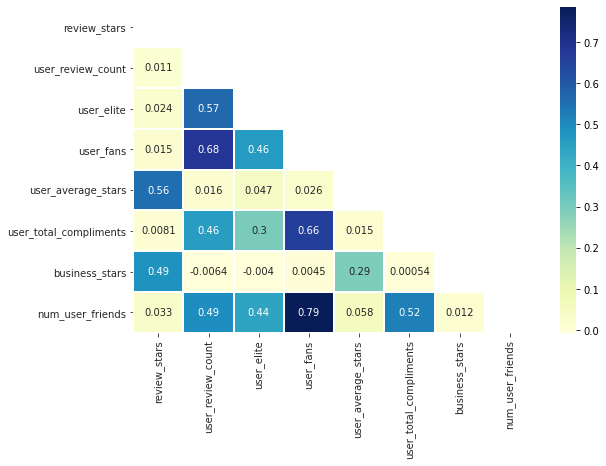

In [3]:
data = df[["review_stars", "review_text_max_150", "user_review_count", "user_elite", "user_fans", "user_average_stars", \
           "user_total_compliments", "business_stars", "num_user_friends"]]
corr_heatmap(data)

In [4]:
X = data[["review_text_max_150", "user_review_count", "user_elite", "user_fans", "user_average_stars", "user_total_compliments", "business_stars", "num_user_friends"]]
y = data["review_stars"]

### Split Train and Test Dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_text = X_train["review_text_max_150"]
X_test_text = X_test["review_text_max_150"]
X_train.drop("review_text_max_150", axis=1, inplace=True)
X_test.drop("review_text_max_150", axis=1, inplace=True)

## Word Embedding

In [37]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train_text)
sequences_train = tokenizer.texts_to_sequences(X_train_text)
sequences_test = tokenizer.texts_to_sequences(X_test_text)

In [38]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 120803 unique tokens.


In [39]:
X_train_text = pad_sequences(sequences_train, maxlen=150)
print('Shape of data train tensor:', X_train_text.shape)

T = X_train_text.shape[1]

X_test_text = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', X_test_text.shape)

Shape of data train tensor: (268540, 150)
Shape of data test tensor: (132267, 150)


In [40]:
X_train_text

array([[    0,     0,     0, ...,   104,   172,   674],
       [    0,     0,     0, ...,   682,   311,    11],
       [    0,     0,     0, ...,  1755,   564,    76],
       ...,
       [    0,     0,     0, ..., 10897,    37,    20],
       [    0,     0,     0, ...,   568,   810,   471],
       [    0,     0,     0, ...,   145,    70,   356]])

### Stochastic Gradient Descent

In [41]:
sgd = SGDRegressor().fit(X_train, y_train)
evaluate(sgd.predict(X_test), y_test)


Linear Regression Performance Metrics
R^2= -1.5651609660326196e+30
MAE: 219330684249049.22
MSE: 3.528955432867246e+30
RMSE: 1878551418744572.5


In [42]:
sgd = SGDRegressor().fit(X_train_text, y_train)
evaluate(sgd.predict(X_test_text), y_test)


Linear Regression Performance Metrics
R^2= -1.0264708625863656e+32
MAE: 1.0352654798169166e+16
MSE: 2.7812950526992724e+32
RMSE: 1.6677215153314034e+16


### Random Forest

In [43]:
rf = RandomForestRegressor().fit(X_train, y_train)
evaluate(rf.predict(X_test), y_test)


Linear Regression Performance Metrics
R^2= 0.3575897521956586
MAE: 0.858972305806689
MSE: 1.432449362119409
RMSE: 1.1968497658935349


In [44]:
rf = RandomForestRegressor().fit(X_train_text, y_train)
evaluate(rf.predict(X_test_text), y_test)


Linear Regression Performance Metrics
R^2= 0.10576628039676328
MAE: 1.1962821288874959
MSE: 1.9954693975370796
RMSE: 1.4126108443365


We can find that Random Forest has a much better result than Stochastic Gradient Descent on both Regression and NLP

# Improve Random Forest

<AxesSubplot:>

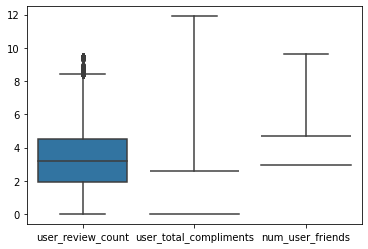

In [12]:
sns.boxplot(data=np.log(X_train[["user_review_count", "user_total_compliments", "num_user_friends"]]))

<AxesSubplot:>

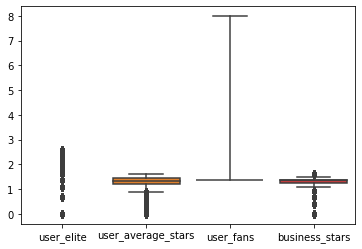

In [15]:
sns.boxplot(data=np.log(X_train[["user_elite", "user_average_stars", "user_fans", "business_stars"]]))

In [45]:
new_X_train = X_train.copy()
new_X_train["user_review_count"] = new_X_train["user_review_count"].apply(lambda x : np.log(x) if x > 0 else 0)
new_X_train["user_average_stars"] = new_X_train["user_average_stars"].apply(lambda x : np.log(x) if x > 0 else 0)
new_X_train["business_stars"] = new_X_train["business_stars"].apply(lambda x : np.log(x) if x > 0 else 0)

new_X_test = X_test.copy()
new_X_test["user_review_count"] = new_X_test["user_review_count"].apply(lambda x : np.log(x) if x > 0 else 0)
new_X_test["user_average_stars"] = new_X_test["user_average_stars"].apply(lambda x : np.log(x) if x > 0 else 0)
new_X_test["business_stars"] = new_X_test["business_stars"].apply(lambda x : np.log(x) if x > 0 else 0)

In [46]:
rf = RandomForestRegressor().fit(new_X_train, y_train)
evaluate(rf.predict(new_X_test), y_test)


Linear Regression Performance Metrics
R^2= 0.35794583966963545
MAE: 0.8586948211401925
MSE: 1.4316287644122063
RMSE: 1.1965069011134897


# Tuning Random Forest

In [ ]:
# This process may take a long time to execute
parameters = {'n_estimators': (10, 100), 'criterion': ('mse', 'mae'), 'max_features': ('auto', 'sqrt', 'log2'), 'oob_score': (True, False)}
clf = GridSearchCV(RandomForestRegressor(), parameters)
clf.fit(X_train, y_train)